In [1]:
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Making an LSTM from scratch

### To start you will be filling in the blanks to create your own LSTM. 
### Here are the equations you will need:

$f_t=σ(W_{fx}\cdot x_t+W_{fh}\cdot h_t+b_f)$

$i_t=σ(W_{ix}\cdot x_t+W_{ih}\cdot h_t+b_i)$

$\tilde c_t=tanh(W_{cx}\cdot x_t+W_{ch}\cdot h_t+b_c)$

$o_t=σ(W_{ox}\cdot x_t+W_{oh}\cdot h_t+b_o)$

$C_t=f_t∗C_t+i_t∗\tilde c_t$

$h_t=o_t∗tanh(C_t)$

### and here are the matrix and vector sizes you will need to know:

$H$ = size of hidden state, $I$ = size of input features

$f_t,i_t,\tilde c_t,o_t,h_t,C_t = H \times 1$ 

$x_t = I \times 1$

$W_{fx},W_{ix},W_{cx},W_{ox} = H \times I$

$W_{fh},W_{ih},W_{ch},W_{oh} = H \times H$

$b_{f},b_{i},b_{c},b_{o} = H \times 1$

In [2]:
class LSTM(nn.Module):
    def __init__(self,inputsz,hiddensz):
        super().__init__()
        self.inputsz=inputsz
        self.hiddensz=hiddensz
        
        #input gate
        self.Wix = Parameter(torch.Tensor(self.hiddensz,self.inputsz))
        self.Wfx = Parameter(torch.Tensor(self.hiddensz,self.inputsz))
        self.Wcx = Parameter(torch.Tensor(self.hiddensz,self.inputsz))
        self.Wox = Parameter(torch.Tensor(self.hiddensz,self.inputsz))
        
        self.bi = Parameter(torch.Tensor(self.hiddensz,1))
        self.bf = Parameter(torch.Tensor(self.hiddensz,1))
        self.bc = Parameter(torch.Tensor(self.hiddensz,1))
        self.bo = Parameter(torch.Tensor(self.hiddensz,1))
        
        
        self.Wfh = Parameter(torch.Tensor(self.hiddensz,self.hiddensz))
        self.Wih = Parameter(torch.Tensor(self.hiddensz,self.hiddensz))
        self.Wch = Parameter(torch.Tensor(self.hiddensz,self.hiddensz))
        self.Woh = Parameter(torch.Tensor(self.hiddensz,self.hiddensz))
        

        #paramter initialization
        for p in self.parameters():  
            if p.data.ndimension()>=2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    def forward(self,x,initstates=None):
        m = len(x)
        hidden_seq = []
        if initstates is None:
            ht,ct = torch.zeros(self.hiddensz,1),torch.zeros(self.hiddensz,1)
        else:
            ht,ct = initstates
        for t in range(m):
            xt = x[t,:]
            it =   torch.sigmoid(self.Wix@xt + self.Wih@ht + self.bi)
            ft =   torch.sigmoid(self.Wfx@xt + self.Wfh@ht + self.bf)
            gt =   torch.tanh(self.Wcx@xt + self.Wch@ht + self.bc)
            ot =   torch.sigmoid(self.Wox@xt + self.Woh@ht + self.bo)
            ct =   ft*ct + it*gt # Dim mismatch
            ht =   ot*torch.tanh(ct)
            hidden_seq.append(ht.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq,dim=0)
        return hidden_seq, (ht,ct)

In [3]:
class customDataset(Dataset):

    def __init__(self, x, transform=None):
        self.data = x
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

# Addition

### First we are going to be teaching the LSTM to do addition.

In [4]:
def addData(size):
    size = np.random.choice(range(size,size+int(size/10)))
    inputs = torch.Tensor([[np.random.uniform(-.5,.5),0] for i in range(size)])
    choice1 = np.random.choice(range(1,10))
    choice2 = list(range(1,int(size/2)))
    choice2.remove(choice1)
    choice2 = np.random.choice(choice2)
    inputs[choice1,1]=1
    inputs[choice2,1]=1
    label = inputs[:,0][inputs[:,1]==1].sum()
    return inputs,label
    

### Here's a look at the data. The goal is to learn to add the numbers in the left row that have a corresponding 1 in the right row while ignoring the rest.

In [5]:
addData(20)

(tensor([[-0.0817,  0.0000],
         [-0.0907,  0.0000],
         [ 0.3083,  0.0000],
         [-0.2643,  0.0000],
         [-0.0813,  0.0000],
         [-0.0877,  0.0000],
         [-0.1156,  0.0000],
         [ 0.3379,  1.0000],
         [ 0.1589,  1.0000],
         [-0.4227,  0.0000],
         [ 0.4473,  0.0000],
         [ 0.0559,  0.0000],
         [-0.2232,  0.0000],
         [-0.2850,  0.0000],
         [-0.3200,  0.0000],
         [-0.3437,  0.0000],
         [-0.4342,  0.0000],
         [ 0.1688,  0.0000],
         [ 0.1955,  0.0000],
         [ 0.1158,  0.0000]]), tensor(0.4968))

In [6]:
size = 20

train = customDataset([addData(size) for i in range(20)])
train_loader = DataLoader(train,batch_size = 1, shuffle = False)

val = customDataset([addData(size) for i in range(20)])
val_loader = DataLoader(val,batch_size = 1, shuffle = False)

test = customDataset([addData(size) for i in range(100)])
test_loader = DataLoader(test,batch_size = 1, shuffle = False)


In [7]:
featsz, hiddensz = 2, 1
model = LSTM(featsz, hiddensz)
# Define hyperparameters
n_epochs = 100
lr=.02

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = .0001)

In [8]:
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz),torch.zeros(hiddensz)
    losslist = []
    for d,t in train_loader:
        optimizer.zero_grad()
        output, hidden = model(d.squeeze(0),hidden)
        loss = criterion(output.sum(), t)
        
        loss.backward(retain_graph=True)
        losslist.append(loss.item())
        optimizer.step()
    model.eval()
    validationlist = []
    for d,t in val_loader:
        output,hidden = model(d.squeeze(0))
        loss = criterion(output.sum(), t)
        validationlist.append(loss.item())
    currval = np.mean(validationlist)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f},val Loss: {:.4f}".format(np.mean(losslist),currval))

Epoch: 1/100............. training: 19.2825,val Loss: 10.4729
Epoch: 2/100............. training: 6.3815,val Loss: 2.2520
Epoch: 3/100............. training: 0.9770,val Loss: 0.3675
Epoch: 4/100............. training: 0.1478,val Loss: 0.2523
Epoch: 5/100............. training: 0.1194,val Loss: 0.2508
Epoch: 6/100............. training: 0.1178,val Loss: 0.2464
Epoch: 7/100............. training: 0.1155,val Loss: 0.2435
Epoch: 8/100............. training: 0.1142,val Loss: 0.2408
Epoch: 9/100............. training: 0.1132,val Loss: 0.2381
Epoch: 10/100............. training: 0.1122,val Loss: 0.2355
Epoch: 11/100............. training: 0.1112,val Loss: 0.2329
Epoch: 12/100............. training: 0.1102,val Loss: 0.2304
Epoch: 13/100............. training: 0.1093,val Loss: 0.2280
Epoch: 14/100............. training: 0.1083,val Loss: 0.2256
Epoch: 15/100............. training: 0.1074,val Loss: 0.2233
Epoch: 16/100............. training: 0.1066,val Loss: 0.2211
Epoch: 17/100............. trai

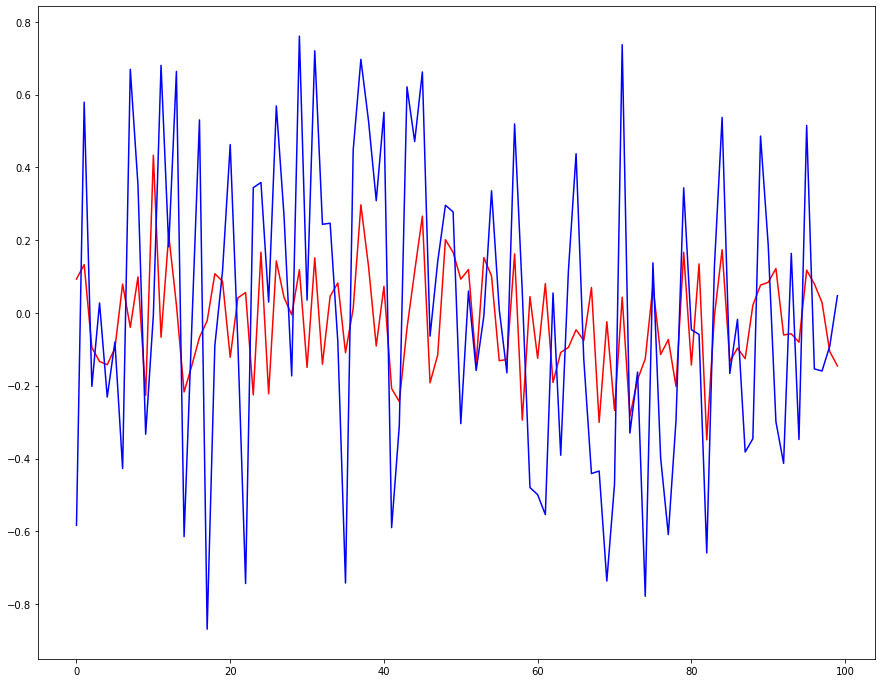

In [9]:
model.eval()
predictions = []
labels = []
for d,t in test_loader:
    output,hidden = model(d.squeeze(0))
    predictions.append(output.sum())
    labels.append(t)
plt.figure(figsize=(15,12))
plt.plot(predictions,'r-')
plt.plot(labels,'b-')

# Multiplication

### Now we'll be trying to learn to multiply. The goal is essentially the same except instead of adding the two numbers we multiply them.

In [10]:
def multData(size):
    size = np.random.choice(range(size,size+int(size/10)))
    inputs = torch.Tensor([[np.random.uniform(0,1),0] for i in range(size)])
    choice1 = np.random.choice(range(1,10))
    choice2 = list(range(1,int(size/2)))
    choice2.remove(choice1)
    choice2 = np.random.choice(choice2)
    inputs[choice1,1]=1
    inputs[choice2,1]=1
    label = inputs[:,0][inputs[:,1]==1].prod()
    return inputs,label

In [11]:
size = 20
train = customDataset([multData(size) for i in range(20)])
train_loader = DataLoader(train,batch_size = 1, shuffle = False)

val = customDataset([multData(size) for i in range(20)])
val_loader = DataLoader(val,batch_size = 1, shuffle = False)


test = customDataset([multData(size) for i in range(40)])
test_loader = DataLoader(test,batch_size = 1, shuffle = False)


In [12]:
featsz, hiddensz = 2, 1
model = LSTM(featsz, hiddensz)
# Define hyperparameters
n_epochs = 1000
lr=.02

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = .0001)

In [14]:
model.train()
minimum = 100
n_epochs = 100
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz),torch.zeros(hiddensz)
    
    losslist = []
    for d,t in train_loader:
        optimizer.zero_grad()
        output, hidden = model(d.squeeze(0),hidden)
        loss = criterion(hidden[0], t)
        loss.backward(retain_graph=True)
        losslist.append(loss.item())
        optimizer.step()
    model.eval()
    validationlist = []
    for d,t in val_loader:
        output,hidden = model(d.squeeze(0))
        predictions.append(hidden[0].item())
        labels.append(t.item())
        loss = criterion(hidden[0], t)
        validationlist.append(loss.item())
    currval = np.mean(validationlist)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f},val Loss: {:.4f}".format(np.mean(losslist),currval))


Epoch: 1/100............. training: 0.0053,val Loss: 0.0230
Epoch: 2/100............. training: 0.0063,val Loss: 0.0287
Epoch: 3/100............. training: 0.0107,val Loss: 0.0277
Epoch: 4/100............. training: 0.0112,val Loss: 0.0207
Epoch: 5/100............. training: 0.0064,val Loss: 0.0227
Epoch: 6/100............. training: 0.0068,val Loss: 0.0245
Epoch: 7/100............. training: 0.0080,val Loss: 0.0243
Epoch: 8/100............. training: 0.0082,val Loss: 0.0229
Epoch: 9/100............. training: 0.0074,val Loss: 0.0225
Epoch: 10/100............. training: 0.0069,val Loss: 0.0227
Epoch: 11/100............. training: 0.0069,val Loss: 0.0229
Epoch: 12/100............. training: 0.0070,val Loss: 0.0228
Epoch: 13/100............. training: 0.0070,val Loss: 0.0225
Epoch: 14/100............. training: 0.0068,val Loss: 0.0222
Epoch: 15/100............. training: 0.0065,val Loss: 0.0221
Epoch: 16/100............. training: 0.0064,val Loss: 0.0221
Epoch: 17/100............. traini

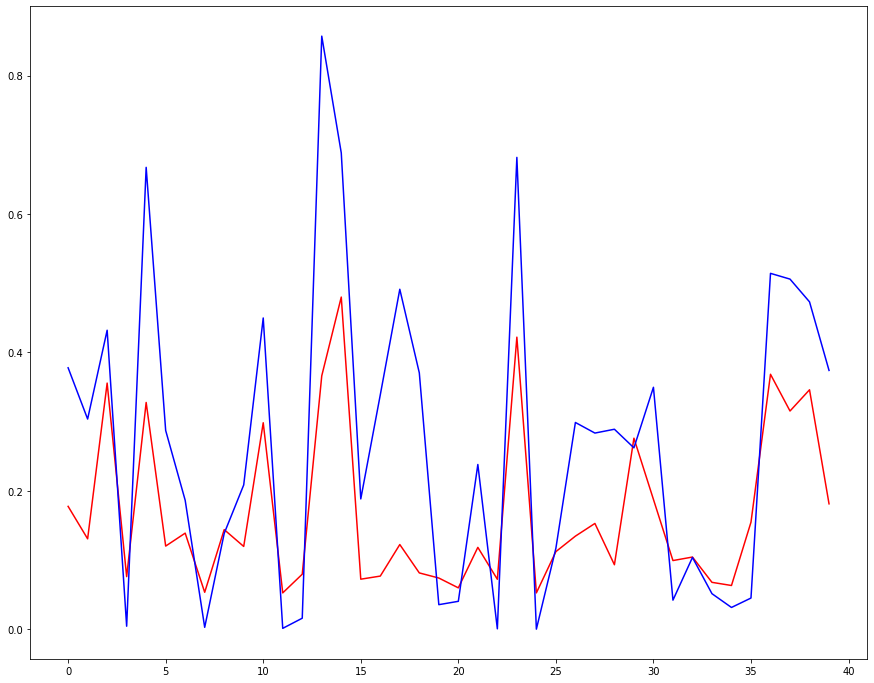

In [15]:
model.eval()
predictions = []
labels = []
for d,t in test_loader:
    output,hidden = model(d.squeeze(0))
    predictions.append(hidden[0])
    labels.append(t)
plt.figure(figsize=(15,12))
plt.plot(predictions,'r-')
plt.plot(labels,'b-')

# Questions

1. Why is addition easy for the LSTM to learn?

Addition is a relatively simply linear function; the sequence gradient is small.
2. Why is multiplication harder for the LSTM to learn?

Multiplication is more difficult because the difference in arbitrary sequence elements can be substantially larger than differences in addition sequences. 

# Language Model

### Here we'll be teaching a model to produce shakespeare. It's a slow a task so we'll be using a more optimized and slightly changed LSTM to do it. The weight matrices have been stacked to reduce the number of matrix multiplications performed and the output now has its own weight matrix. You just need to fill in the function with the correct part of the gates matrix.

In [16]:
class betterLSTM(nn.Module):
    def __init__(self,inputsz,hiddensz):
        super().__init__()
        self.inputsz=inputsz
        self.hiddensz=hiddensz
        
        #input gate
        self.Wx =  Parameter(torch.Tensor(hiddensz*4,inputsz))
        self.Wh = Parameter(torch.Tensor(hiddensz*4,hiddensz))
        self.Wy = Parameter(torch.Tensor(inputsz,hiddensz))
        self.by = Parameter(torch.Tensor(inputsz,1))
        self.b = Parameter(torch.Tensor(hiddensz*4,1))
        #paramter initialization
        for p in self.parameters():
            if p.data.ndimension()>=2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
        self.i = self.hiddensz
        self.f = 2*self.hiddensz
        self.g = 3*self.hiddensz
    
        
    def forward(self,x,initstates=None):
        m = len(x)
        hidden_seq = []
        if initstates is None:
            ht,ct = torch.zeros(self.hiddensz,1),torch.zeros(self.hiddensz,1)
        else:
            ht,ct = initstates
        xt = x
        gates = self.Wx@xt+self.Wh@ht+self.b
        it =   torch.sigmoid(self.Wx[:self.i,:]@x + self.Wh[:self.i,:]@ht + self.b[:self.i])
        ft =   torch.sigmoid(self.Wx[self.i:self.f,:]@xt + self.Wh[self.i:self.f,:]@ht + self.b[self.i:self.f,:])
        gt =   torch.tanh(self.Wx[self.f:self.g,:]@xt + self.Wh[self.f:self.g,:]@ht + self.b[self.f:self.g,:])
        ot =   torch.sigmoid(self.Wx[self.g:,:]@xt + self.Wh[self.g:,:]@ht + self.b[self.g:,:])
        ct =   ft*ct + it*gt # Dim mismatch
        ht =   ot*torch.tanh(ct)
            
            
        ct = ft*ct+it*gt
        ht = ot*torch.tanh(ct)
        output = self.Wy@ht+self.by
        return output, (ht,ct)

### Here we load the data and transform it into one-hot vectors.

In [17]:
file = open('clean_shakespeare.txt','r')
text = file.read()
letters = 'abcdefghijklmnopqrstuvwxyz '
# one hot encode characters
char_dict = {}
for i,char in enumerate(letters):
    vec = torch.zeros(27)
    vec[i] += 1
    char_dict[char] = vec

total_data = 40000

D = []
for i in range(total_data):
    x = text[i]
    y = text[i+1]
    D.append((char_dict[x],char_dict[y]))


featsz, hiddensz = 27, 64
model = betterLSTM(featsz, hiddensz)

### This function generates text with our model. You can try different seeds to see what you get. "rand" influences randomness in the text generation and "size" determines how many characters will be produced.

In [18]:
seed = 'to be or not to be that is the question'
def text_gen(model,seed,rand=5,h_size=32,size=100):
    n = len(seed)
    one_hot = torch.zeros(n,27)
    for i in range(n):
        one_hot[i] = char_dict[seed[i]]
    hidden = torch.zeros(hiddensz,1),torch.zeros(hiddensz,1)
    last_char = ''
    for vec in one_hot:
        y_hat,hidden = model(vec.unsqueeze(1),hidden)
        out = y_hat.permute((1,0))
    char = letters[torch.argmax(out)]
    seed += char
    for i in range(size):
        last_char = char
        y_hat,hidden = model(char_dict[last_char].unsqueeze(1),hidden)
        out = y_hat.permute((1,0))
        if last_char == ' ':
            best = torch.argsort(out)
            best = best[-rand:]
            char = np.random.choice(best.squeeze(0))
            char = letters[char]
        else:
            char = torch.argmax(out)
            char = letters[char]
        seed += char
    return seed

In [19]:
train = customDataset(D)
train_loader = DataLoader(train,batch_size = 1, shuffle = False)
lr = .001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### We truncated the back propogation to speed things up. You can try different values of truncation to see how it performs. 

### DB COMMENT: Is this really truncation as we usually understand it?  It looks like we're just ignoring most of the training data via this "truncation term"...

In [20]:
n_epochs = 30
truncate = 32
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz,1),torch.zeros(hiddensz,1)
    losslist = []
    i = 1
    loss = 0
    for d,t in train_loader:
        if i%truncate==0:
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
            loss = 0
            hidden = (hidden[0].data,hidden[1].data)
        output, hidden = model(d.permute((1,0)),hidden)
        loss += criterion(output.permute((1,0)),t.argmax(dim=1))
        losslist.append(loss.item())
        i += 1
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f}".format(np.mean(losslist)))
    model.eval()
    print(text_gen(model,seed,size=1000,rand=10,h_size=hiddensz))

Epoch: 1/30............. training: 39.0498
to be or not to be that is the question ghath xore when fore ghath ghath lout lout chand yout nout ghath routh en dore chand xore ghat ghat rout or qore dore  dore beath chath en qore pare beath pare lo ere kore pare jore ghat en love qore beath dore beath zore kore veand yout veand zore lout when ghat rout fore eath beath routh in ghat fore in qore and hot veand jore lout ho  hath dore rout  xore pare when fore jore veand ghath veand the veand chand pare veand kore yout eath hoth jore and beath yout pare  sand  uin ho keath on xore pare dore the what sout yout ghath hong kore when veand and mand yout kong fore veand sore lout in zore rout meand kore dore ure sore when shath routh not lout ghat and kore dore ghat or beath zore veand jore yout veand lout xore ghat and jore in mong chath yout rout xore veand mong xore kore jore when eath whath fore in zore  uin or yout the zath fore zore the what ho ghat of ghath yout of in zore pare of fore whe

# Questions

1. What is the purpose of truncated back-prop? 


2. Say we truncate back-propagation at 50 time steps. Can the cell state carry information from more
    than 50 time steps back?

1. To speed up the optimization; would be pretty slow without it

2. Yes, our sequence length is long enough for that to work.